## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_WIDTH  = 64
IMG_HEIGHT = 64

## Create a sampling layer

In [4]:
# Clear all previously registered custom objects
keras.saving.get_custom_objects().clear()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        config = super().get_config()
        return config

## Build the encoder

In [5]:
latent_dim = 512
def build_encoder():
    encoder_inputs = keras.Input(shape=(64, 64, 3))
    # x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
    # x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()

I0000 00:00:1731637629.819040    6284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731637629.839213    6284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731637629.839253    6284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731637629.840833    6284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731637629.840867    6284 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,624 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 8)   │      1,160 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 512)       │    262,656 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 512)       │    262,656 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 512)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 794,648 (3.03 MB)

 Trainable params: 794,648 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

## Build the decoder

In [6]:
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    # x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    decoder_outputs = layers.Conv2DTranspose(3, (3,3), activation="relu", padding="same", strides=2)(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,176,003 (8.30 MB)

 Trainable params: 2,176,003 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

## Define the VAE as a `Model` with a custom `train_step`

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [8]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [9]:
from tqdm import tqdm
import cv2
def load_images_from_folder(folder, subfolder):
    images = []
    gray = []
    # lab = []
    foldername = os.path.join(folder, subfolder)
    for sub in os.listdir(foldername):
        subfoldername = os.path.join(foldername, sub)
        for filename in tqdm(os.listdir(subfoldername)):
            img = cv2.imread(os.path.join(subfoldername, filename))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        # convert the image to RGB (images are read in BGR in OpenCV)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            if img is not None:
                images.append(img/255.0)
                gray.append(gry)
                # lab.append(label)
    return np.array(images), np.array(gray)

In [10]:
caries, caries_gray = load_images_from_folder(dataset, "Caries")
gingivitis, gingivitis_gray = load_images_from_folder(dataset, "Gingivitis")
wsl, wsl_gray = load_images_from_folder(dataset, "White Spot Lesion")

100%|██████████| 1/1 [00:00<00:00, 25.51it/s]


In [11]:
def train_vae(images):
    encoder = build_encoder()
    decoder = build_decoder()
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    history = vae.fit(images, epochs=150, batch_size=48)
    return history, vae

In [12]:
def save_vae(model_name, vae):
    encoder_path = model_folder + "/" + model_name + "_encoder.h5"
    decoder_path = model_folder + "/" + model_name + "_decoder.h5"
    vae.encoder.save(encoder_path)
    vae.decoder.save(decoder_path)
    vae.save(model_folder + "/" + model_name + ".h5")
    print(model_name, " Model saved")

In [13]:
import matplotlib.pyplot as plt
import json


def show_history(history, model_name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['reconstruction_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    history_file = history_folder + "/" + model_name + "_history.json"
    json.dump(history_dict, open(history_file, 'w'))

In [14]:
caries_history, caries_vae = train_vae(caries)
gingivitis_history, gingivitis_vae = train_vae(gingivitis)
wsls_history, wsls_vae = train_vae(wsl)

Epoch 1/150


I0000 00:00:1731637634.713287    6353 service.cc:146] XLA service 0x7f85d0003f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731637634.713325    6353 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - kl_loss: 0.8753 - loss: 15980.0010 - reconstruction_loss: 15979.1260
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 1.2806 - loss: 13886.3555 - reconstruction_loss: 13885.0752
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 1.8443 - loss: 12334.6426 - reconstruction_loss: 12332.7979
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 1.9912 - loss: 10721.1289 - reconstruction_loss: 10719.1377
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 2.3517 - loss: 9431.3164 - reconstruction_loss: 9428.9648
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 2.5375 - loss: 8524.9668 - reconstruction_loss: 8522.4297
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 3.6013 - loss: 7753.9829 - reconstruction_loss: 7750.3818
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 4.3145 - loss: 7056.9209 - reconstruction_loss: 7052.6064
Epoch 9/150


I0000 00:00:1731637638.966314    6353 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 4.7408 - loss: 6534.2046 - reconstruction_loss: 6529.4639
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 5.2715 - loss: 6168.3154 - reconstruction_loss: 6163.0439
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 5.8135 - loss: 5866.1851 - reconstruction_loss: 5860.3716
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - kl_loss: 6.5937 - loss: 5620.1050 - reconstruction_loss: 5613.5112
Epoch 13/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 7.7269 - loss: 5355.3511 - reconstruction_loss: 5347.6240
Epoch 14/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - kl_loss: 9.2335 - loss: 5133.6934 - reconstruction_loss: 5124.4600
Epoch 15/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - kl_loss: 11.1270 - loss: 4950.4629 - reconstruction_loss: 4939.3359
Epoch 16/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - kl_loss: 14.3412 - loss: 4749.3960 - reconstruction_loss: 4735.0547
Epoch 17/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 

In [15]:
save_vae("caries_512", caries_vae)
save_vae("gingivitis_512", gingivitis_vae)
save_vae("wsl_512", wsls_vae)

caries_512  Model saved


gingivitis_512  Model saved
wsl_512  Model saved


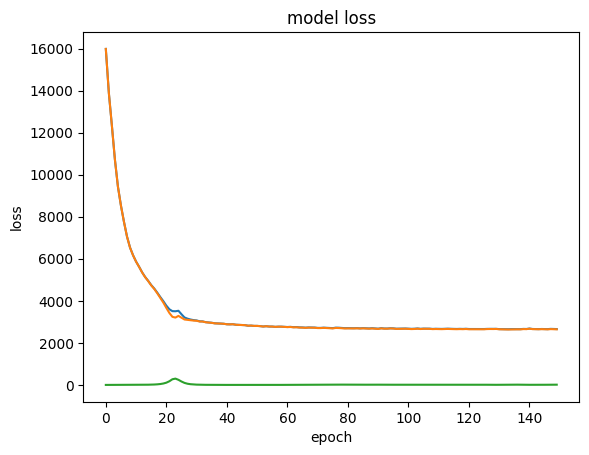

In [17]:
show_history(caries_history, "caries_512")

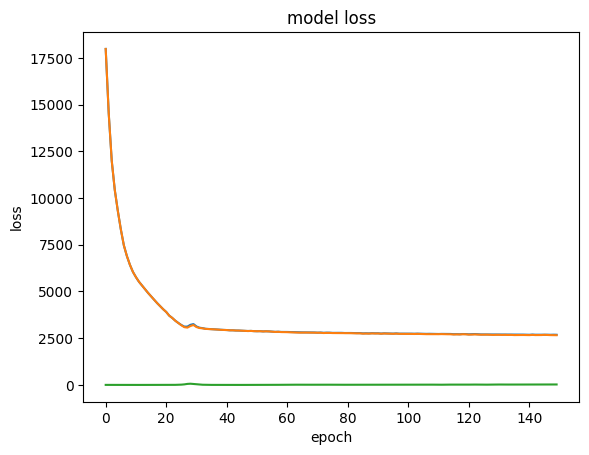

In [18]:
show_history(gingivitis_history, "gingivitis_512")

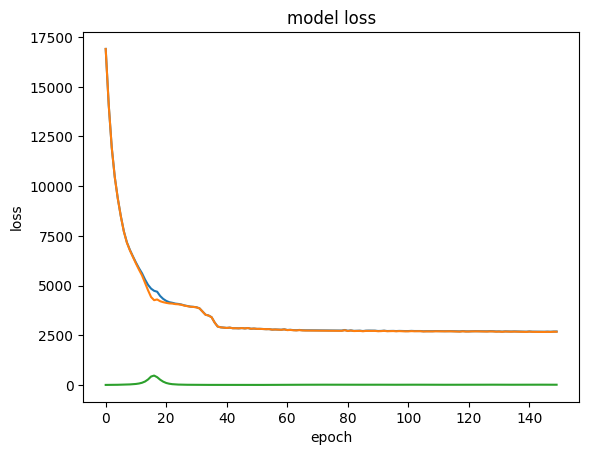

In [19]:
show_history(wsls_history, "wsl_512")

In [20]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [21]:
def test_vae(images, encoder, decoder):
    predictions = encoder.predict(images)
    predictions = decoder.predict(predictions[2])
    show_images(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


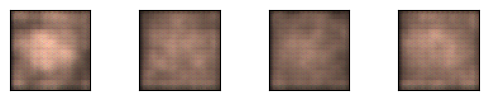

In [22]:
test_vae(caries, caries_vae.encoder, caries_vae.decoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


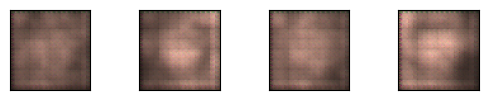

In [23]:
test_vae(gingivitis, gingivitis_vae.encoder, gingivitis_vae.decoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


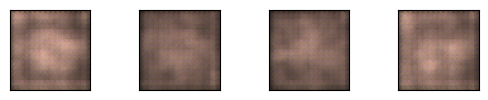

In [24]:
test_vae(wsl, wsls_vae.encoder, wsls_vae.decoder)